In [1]:
from common import hallmark as hm
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from common import dalt
import imageio
from common import io_ipole as io

In [61]:
pf_SPO = hm.ParaFrame('spectral_index/img_dump/SPO/SgrA_{aspin:g}_{freq}_{inc}.h5')
pf_beta = hm.ParaFrame('spectral_index/img_dump/beta/SgrA_{aspin:g}_{freq}_{inc}.h5')

for k in set(pf_SPO.keys()) - {'path'}:
    globals()[k] = np.unique(pf_SPO[k])
    print(k, globals()[k][:16])

def get_df(path):
    df = pd.read_csv(path, sep='\t')
    return df

def get_intensity_map(path, s=0, **kwwargs):
    hfp = h5py.File(path,'r')    
    imagep = np.copy(hfp['pol']).transpose((1,0,2))
    if s == 0:
        I = imagep[:,:,0]
    if s == 1:
        I = imagep
    return I


def get_alpha_map(pf, **kwargs):
    sel_low = pf(freq=freq[0])
    sel_high = pf(freq=freq[1])

    I_low = get_intensity_map(sel_low.path.iloc[0], **kwargs)
    I_high = get_intensity_map(sel_high.path.iloc[0], **kwargs)

    avg_I = (I_low + I_high) / 2

    numerator = np.log(I_low / I_high)
    denominator = np.log(float(freq[0]) / float(freq[1]))

    alpha = numerator / denominator
    alpha_index = (np.sum(avg_I * alpha) / np.sum(avg_I))
    
    # Scaling the opacity according to intensity
    opacity = avg_I / np.max(avg_I)
    opacity[avg_I > np.max(avg_I) * 0.8] = 1
    return alpha, opacity, alpha_index

def colorbar(mappable):
  """ the way matplotlib colorbar should have been implemented """
  from mpl_toolkits.axes_grid1 import make_axes_locatable
  ax = mappable.axes
  fig = ax.figure
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  return fig.colorbar(mappable, cax=cax)

def vizrow(pf, viz_type, v='2141.e8', label=None, **kwargs):
    fig, axes = plt.subplots(1, 5, figsize=(15,15), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.3, hspace=0)
    print(f"Rendering frequency {v}")

    lst = []

    if viz_type == 'alpha':
        alpha_list = []
        for a, ax in enumerate(axes):
            sel = pf(aspin=aspin[a])
            alpha, opacity, alpha_index = get_alpha_map(sel, **kwargs)
            alpha_list.append(np.mean(alpha_index))
            tmp = axes[a].imshow((alpha.T), origin='lower', cmap='jet', alpha=opacity, **kwargs)
            #tmp = axes[a].imshow(alpha, origin='lower', cmap='jet', **kwargs)
            colorbar(tmp)

            ax.set_title(f"$a_\mathrm{{spin}}={str(aspin[a])}$")

            lst.append(alpha)

        return alpha_list

    elif viz_type == 'I':
        for a, ax in enumerate(axes):
            sel = pf(aspin=aspin[a])(freq=v)
            _, _, _, _, img = io.load_summ(sel.path.iloc[0])

            I = img.value[:,:,0]
            im = axes[a].imshow((I.T), cmap='afmhot', origin='lower', **kwargs)  
            colorbar(im)
            axes[a].set_title(f"$a_\mathrm{{spin}}={str(aspin[a])}$")

            lst.append(I)

    elif viz_type == 'LP':
        for a, ax in enumerate(axes):
            sel = pf(aspin=aspin[a])(freq=v)
            _, _, _, _, img = io.load_summ(sel.path.iloc[0])

            I = img.value[:,:,0]
            Q = img.value[:,:,1]
            U = img.value[:,:,2]

            lp = np.sqrt(Q*Q+U*U)
            im = axes[a].imshow((lp.T), cmap='afmhot', origin='lower', **kwargs)  
            colorbar(im)
            axes[a].set_title(f"$a_\mathrm{{spin}}={str(aspin[a])}$")

            lst.append(lp)

    elif viz_type == 'LP_frac':
        for a, ax in enumerate(axes):
            sel = pf(aspin=aspin[a])(freq=v)
            _, _, _, _, img = io.load_summ(sel.path.iloc[0])

            I = img.value[:,:,0]
            Q = img.value[:,:,1]
            U = img.value[:,:,2]

            Imaskval = np.abs(I.min()) * 100.
            Imaskval = np.nanmax(I) / np.power(I.shape[0],5.)
            

            lpfrac = 100.*np.sqrt(Q*Q+U*U)/I
            lpfrac[np.abs(I)<Imaskval] = np.nan
            ax.set_facecolor('black')
            im = ax.imshow(lpfrac.T, cmap='jet', vmin=0., vmax=100., origin='lower', )
            colorbar(im)
            axes[a].set_title(f"$a_\mathrm{{spin}}={str(aspin[a])}$")

            lst.append(lpfrac)

    elif viz_type == 'tauI':

        for a, ax in enumerate(axes):
            sel = pf(aspin=aspin[a])(freq='2141.e8')
            _, _, _, _, img = io.load_summ(sel.path.iloc[0])

            tau = img.tauI
            I = img.value[:,:,0]
            print(np.sum(tau * I) / np.sum(I))
            im = axes[a].imshow(tau.T, cmap='jet', origin='lower')  
            colorbar(im)
            axes[a].set_title(f"$a_\mathrm{{spin}}={str(aspin[a])}$")

            lst.append(tau)

    elif viz_type == 'EVPA':

        for a, ax in enumerate(axes):
            sel = pf(aspin=aspin[a])(freq='2141.e8')
            _, _, _, _, img = io.load_summ(sel.path.iloc[0])

            I = img.value[:,:,0]
            Q = img.value[:,:,1]
            U = img.value[:,:,2]

            Imaskval = np.abs(I.min()) * 100.
            Imaskval = np.nanmax(I) / np.power(I.shape[0],5.)

            evpa = (180./3.14159)*0.5*np.arctan2(U,Q)
            evpa += 90.
            evpa[evpa > 90.] -= 180.
            evpa[np.abs(I)<Imaskval] = np.nan
            ax.set_facecolor('black')
            im = axes[a].imshow(evpa, cmap='hsv', vmin=-90., vmax=90., origin='lower', interpolation='none')
            colorbar(im)
            axes[a].set_title(f"$a_\mathrm{{spin}}={str(aspin[a])}$")

            lst.append(evpa)

    if label is not None:
        print(label)
        axes[0].set_ylabel(label)
    plt.tight_layout()

    return lst

inc ['30']
freq ['2141.e8' '2281.e8']
aspin [-0.94 -0.5   0.    0.5   0.94]


Rendering frequency 2141.e8
Rendering frequency 2141.e8


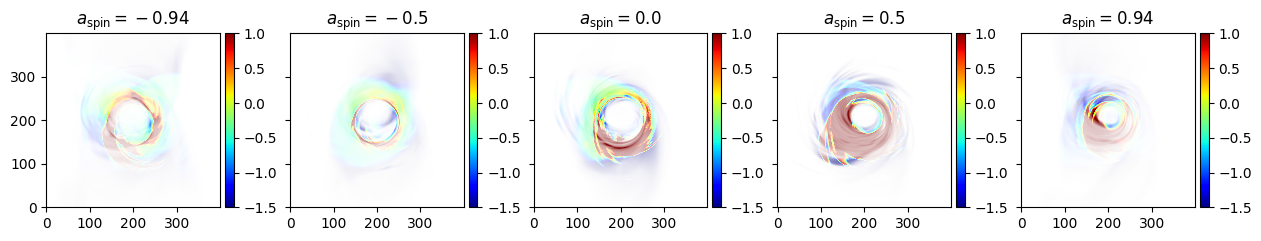

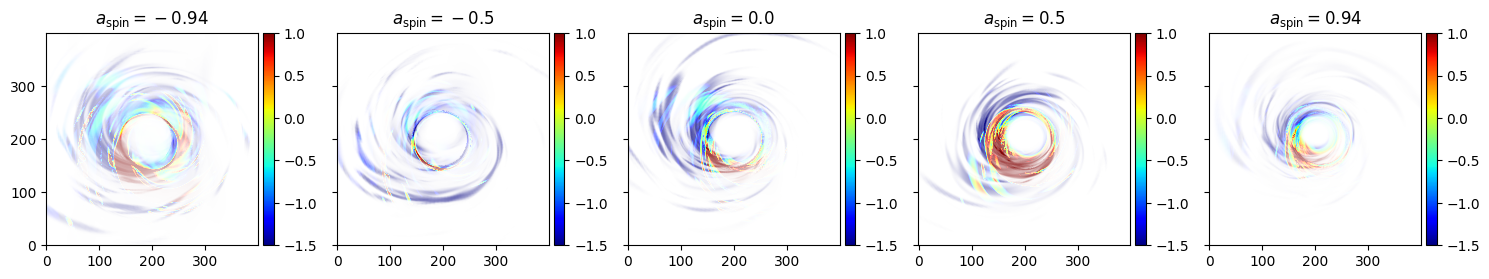

In [62]:
alpha_beta = vizrow(pf_beta, vmax=1, vmin=-1.5, viz_type='alpha', label=r'$R_{low}-R_{high}$')
alpha_SPO = vizrow(pf_SPO, vmax=1, vmin=-1.5, viz_type='alpha', label=r'SPO')
plt.tight_layout()

Following the EHT 2018 observation, we compute images of a single snapshot at 
214.1 GHz and 228.1 GHz for the spectral map in Figure~\ref{fig:spec_index}.
Both models have clear positive spectral distribution around the inner accretion
disk region. This is expected as this region has the highest electron temperature
and the highest optical depth region. As discussed in~\cite{c}, these factors
lead to an increase in the spectral indices. As $\Rl-\Rh$ modle has a much higher
optical depth in the inner accretion flow region, this also leads to a 
relatively larger spectral indices than \SPO model in such region.

The effect of \SPO model having a more negative spectral indices than
$\Rl-\Rh$ model in outer accretion is due to the emission region. In the
chosen snapshot, the emission region of $\Rl-\Rh$ region is more concentrated
around the black hole region, while \SPO model generates a more spread
out spiral arm stucture in the outer accertion disk region. However,
both models show an decrease in spectral indices in these region
due to the decreasing electron temperature.

In the observation of the Atacama Large Millimeter Array (ALMA), $\alpha$ 
is measured to be $0.0\pm0.1$ ~\citep{2023MNRAS.519.4203R,2022ApJ...930L..19W}.
We compute the intensity-weighted spectral index by
\begin{equation}
    \alpha=\frac{\int I(x,y) \alpha (x,y) dxdy}{\int I(x,y) dxdy}
\end{equation}
We found that \SPO model generates images with more negative index than
$\Rl-\Rh$ model, which can be attributed to the extended spiral structure
in the chosen snapshot. However, no snapshot fall into the range of 
$\alpha=0\pm0.1$. A more comprehensive studies can be done by 
considering temporal-averaged images.

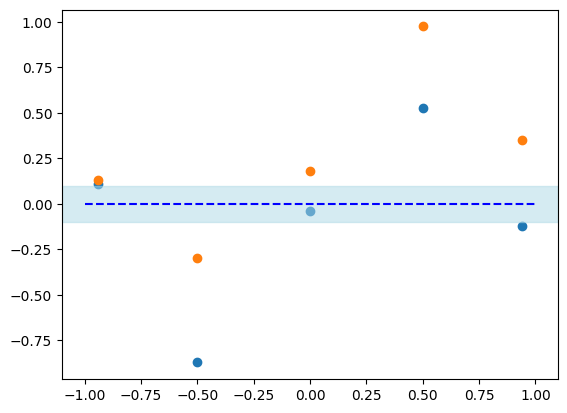

In [54]:
plt.scatter(aspin, alpha_SPO)
plt.scatter(aspin, alpha_beta)
plt.hlines(0, -1, 1, colors='b', linestyles='--')
plt.axhspan(-0.1, 0.1, color='lightblue', alpha=0.5)

Rendering frequency 2281.e8
Rendering frequency 2281.e8
Rendering frequency 2281.e8
2.616406946027212
0.7903025574078457
1.644214515570952
10.629125852589656
5.575788358292009


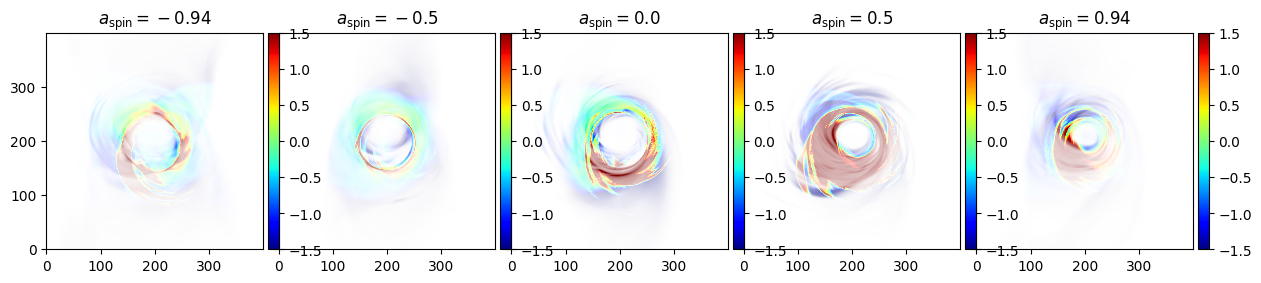

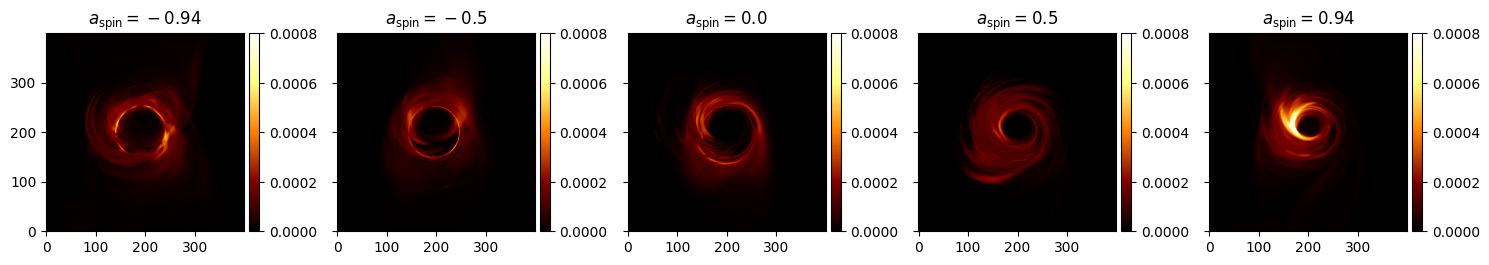

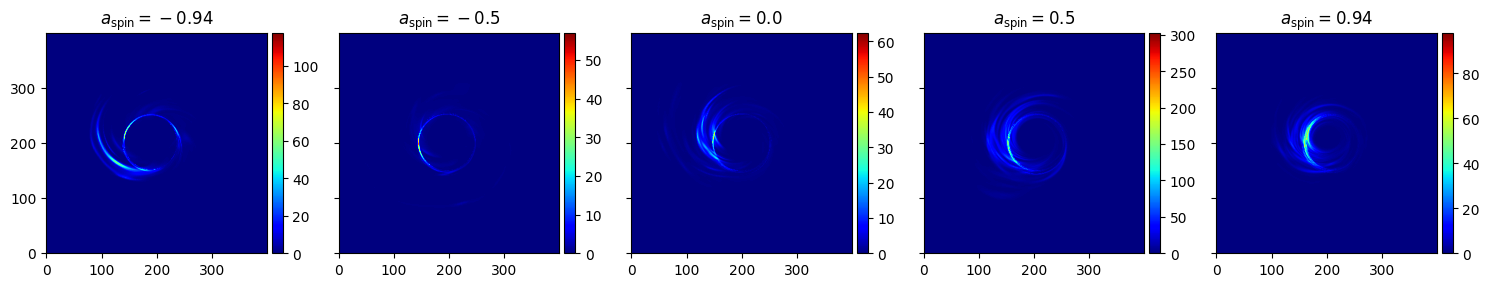

In [34]:
from common import io_ipole as io

v = freq[1]
alpha = vizrow(pf_beta, viz_type='alpha', vmax=1.5, vmin=-1.5, v=v)
I2 = vizrow(pf_beta, viz_type='I', vmax=0.0008, vmin=0, v=v)
tauI = vizrow(pf_beta, viz_type='tauI',v=v)

Rendering frequency 2281.e8
Rendering frequency 2281.e8
Rendering frequency 2141.e8
3.6768692018526643
1.0067405614549396
1.9404513364588618
2.281262320756194
1.0764059768011365


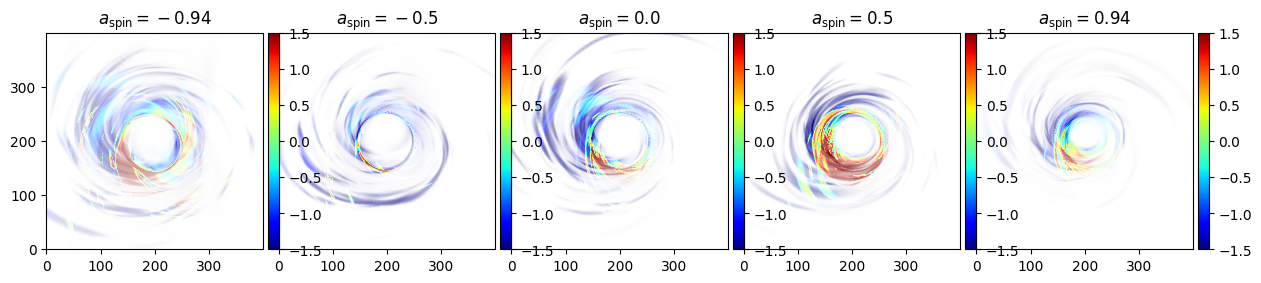

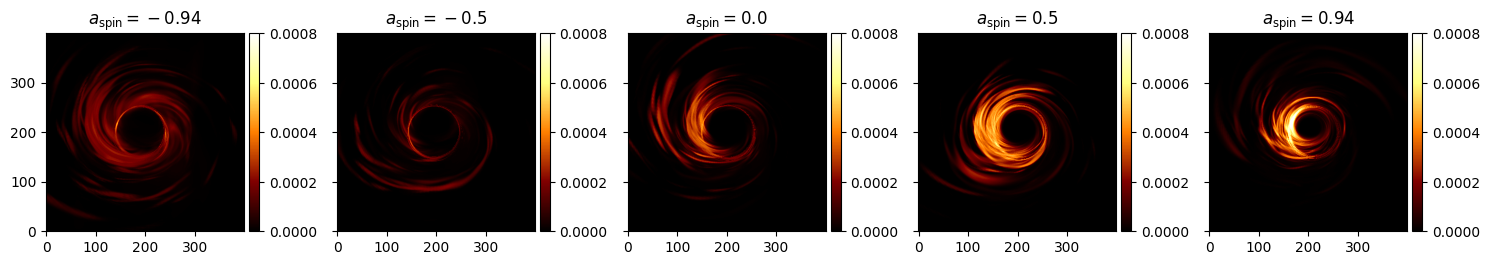

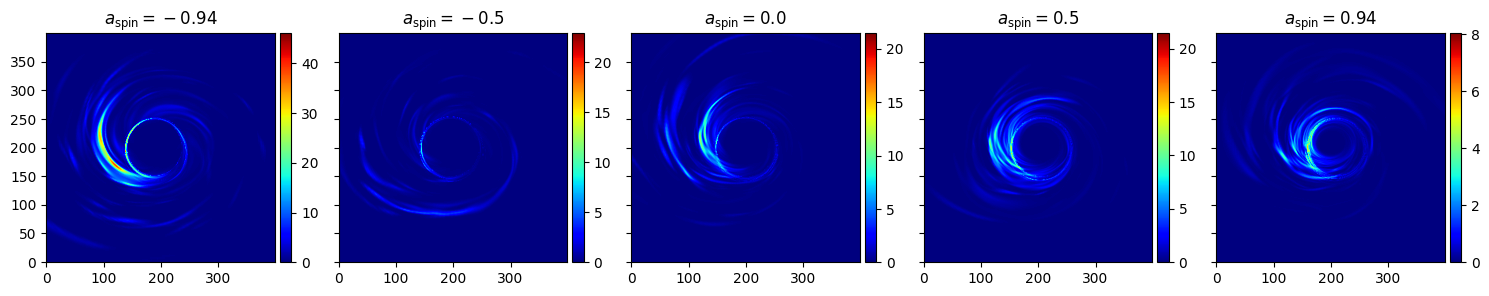

In [35]:
from common import io_ipole as io

v = freq[1]
alpha = vizrow(pf_SPO, viz_type='alpha', vmax=1.5, vmin=-1.5, v=v)
I2 = vizrow(pf_SPO, viz_type='I', vmax=0.0008, vmin=0, v=v)
tauI = vizrow(pf_SPO, viz_type='tauI',v=freq[0])

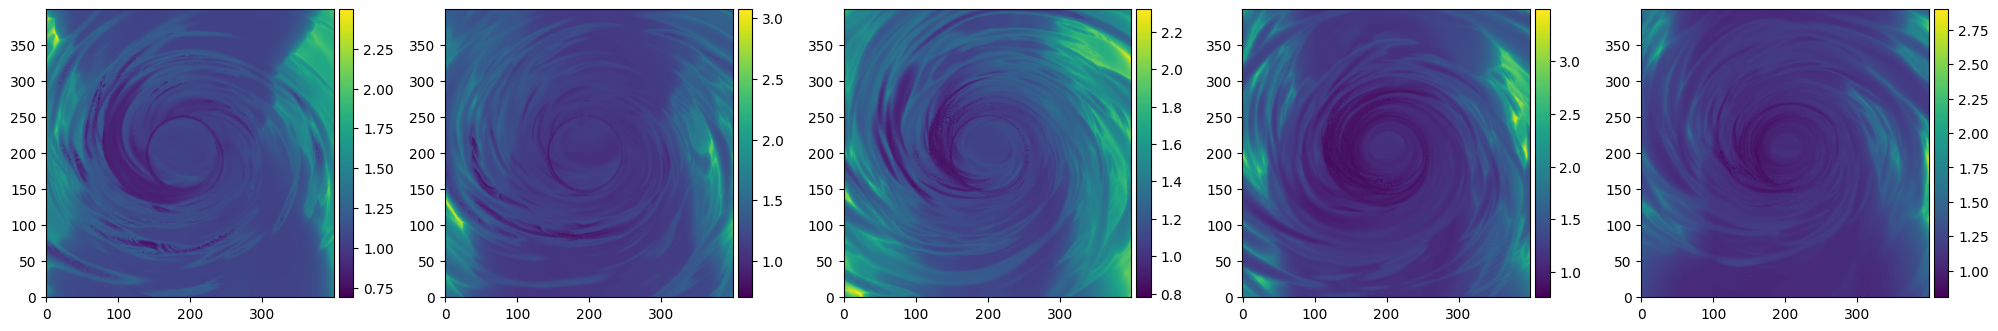

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(20,20))
for i in range(5):
    tmp = I1[i]/I2[i]
    colorbar(ax[i].imshow(tmp.T,origin='lower'))
plt.tight_layout()

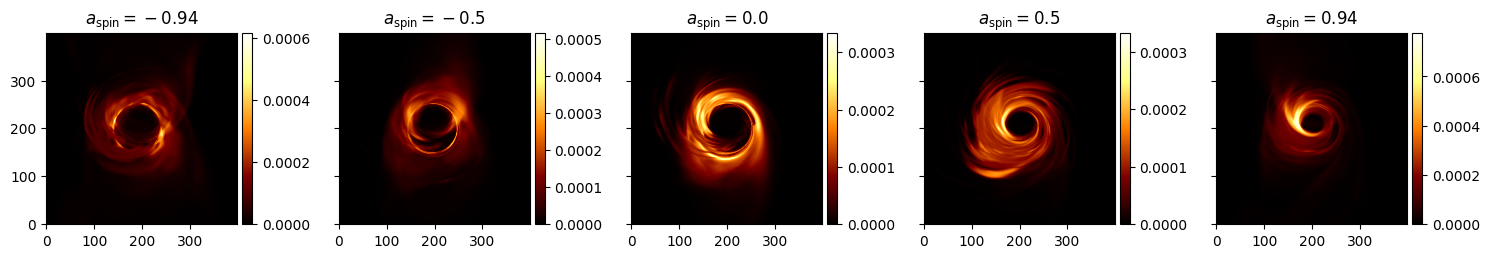

In [ ]:
from common import io_ipole as io

fig, axes = plt.subplots(1, 5, figsize=(15,15), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)

for a, ax in enumerate(axes):
    sel = pf_beta(aspin=aspin[a])(freq='2141.e8')
    _, _, _, _, img = io.load_summ(sel.path.iloc[0])

    I = img.value[:,:,0]
    im = axes[a].imshow(I.T, cmap='afmhot', origin='lower')  
    colorbar(im)
    axes[a].set_title(f"$a_\mathrm{{spin}}={str(aspin[a])}$")
plt.tight_layout()

# Finding $\tau_v$

3.6768692018526643
1.0067405614549396
1.9404513364588618
2.281262320756194
1.0764059768011365


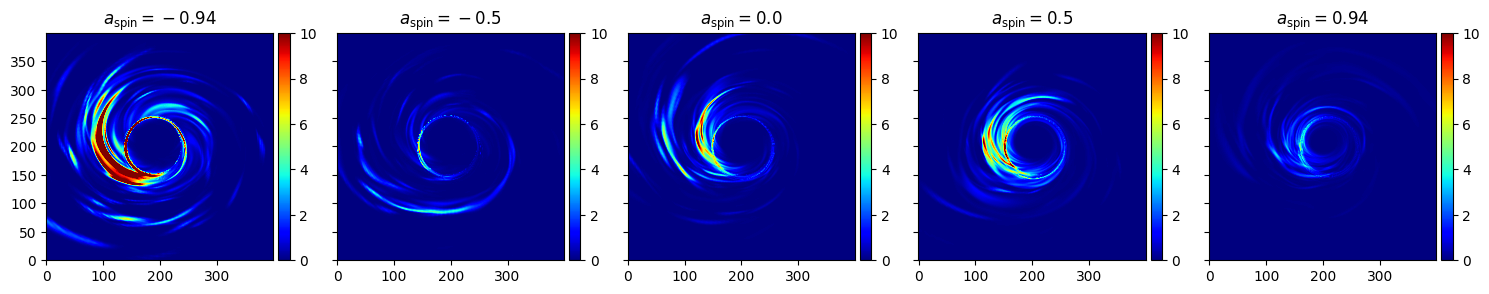

In [ ]:
from common import io_ipole as io

fig, axes = plt.subplots(1, 5, figsize=(15,15), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)

for a, ax in enumerate(axes):
    sel = pf_SPO(aspin=aspin[a])(freq='2141.e8')
    _, _, _, _, img = io.load_summ(sel.path.iloc[0])

    tau = img.tauI
    I = img.value[:,:,0]
    print(np.sum(tau * I) / np.sum(I))
    im = axes[a].imshow(tau.T, cmap='jet', vmax=10, origin='lower')  
    colorbar(im)
    axes[a].set_title(f"$a_\mathrm{{spin}}={str(aspin[a])}$")
plt.tight_layout()

2.2727615229846916
0.6835006446655115
1.419422123029417
8.842641565662724
4.775198637364625


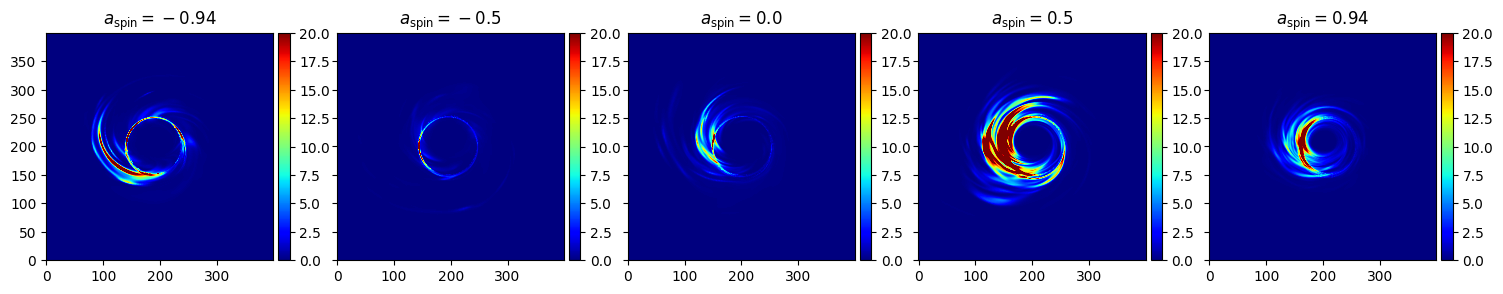

In [ ]:
# Intensity-averaged optical density
from common import io_ipole as io

fig, axes = plt.subplots(1, 5, figsize=(15,15), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)

for a, ax in enumerate(axes):
    sel = pf_beta(aspin=aspin[a])(freq='2281.e8')
    _, _, _, _, img = io.load_summ(sel.path.iloc[0])

    tau = img.tauI
    I = img.value[:,:,0]
    print(np.sum(tau * I) / np.sum(I))
    im = axes[a].imshow(tau.T, cmap='jet', vmax=20, origin='lower')  
    colorbar(im)
    axes[a].set_title(f"$a_\mathrm{{spin}}={str(aspin[a])}$")
plt.tight_layout()